# Classifying genetic mutations from text-based clinical descriptions

<b>Presenter: Jong Shin<br>
Course: BIOF 509 / Dr. Martin Skarzynski<br>
Date: 12/4/2019<br></b>

<img src='img/title_image.jpg'>

### Background

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated. But this is only partially happening due to the huge amount of manual work still required. Memorial Sloan Kettering Cancer Center (MSKCC) launched this competition, accepted by the NIPS 2017 Competition Track, because we need your help to take personalized medicine to its full potential.

<div align=right>excerpted from <i>https://www.kaggle.com/c/msk-redefining-cancer-treatment</i></div>



### Aim

The goal of the competition was to develop an alorithm to classify genetic mutations based on the clinical evidence

### Dataset

##### Link to database

https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

##### Description
   * 3321 rows of patient information with 5 given features

##### List of features
* ID
* Gene
* Variation
* Class
* Text

#### List of files in directory

In [1]:
#%ls msk_dataset
import glob

glob.glob('msk_dataset/*')

['msk_dataset\\stage1_solution_filtered.csv',
 'msk_dataset\\stage2_sample_submission.csv',
 'msk_dataset\\stage2_sample_submission.csv.7z',
 'msk_dataset\\stage2_test_text.csv',
 'msk_dataset\\stage2_test_variants.csv',
 'msk_dataset\\stage_2_private_solution.csv',
 'msk_dataset\\test_text',
 'msk_dataset\\test_variants.zip',
 'msk_dataset\\training_text',
 'msk_dataset\\training_variants.zip']

We will start by studying <b>training_variants.zip</b>

### Importing modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_variants = pd.read_csv('msk_dataset/training_variants.zip') #load the file
#test_variants = pd.read_csv('msk_dataset/test_variants.zip')
train_variants.head(10)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [4]:
train_variants.shape

(3321, 4)

### Unique variables in the dataset

In [5]:
for i in train_variants:
    print(i, ':', len(set(train_variants[i])))
    #plt.bar(i, len(set(train_variants[i])))    

ID : 3321
Gene : 264
Variation : 2996
Class : 9


There are <b>9</b> classes of genetic mutations.<br>
But this involves <b>264</b> genes with unique variations (ie. mutations) that are <u>as many as the number of patients</u>!<br>
Now let's see how frequently each class appear in the dataset

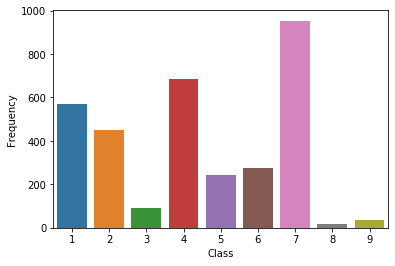

In [6]:
ax = sns.countplot(x='Class', data=train_variants)

ax.set(ylabel = 'Frequency');

Next, let's study which genes are most frequently associated with each class

class 1 : TP53 ( 83 counts)
class 2 : EGFR ( 45 counts)
class 3 : BRCA1 ( 15 counts)
class 4 : PTEN ( 115 counts)
class 5 : BRCA1 ( 90 counts)
class 6 : BRCA2 ( 84 counts)
class 7 : EGFR ( 84 counts)
class 8 : BCOR ( 4 counts)
class 9 : SF3B1 ( 15 counts)


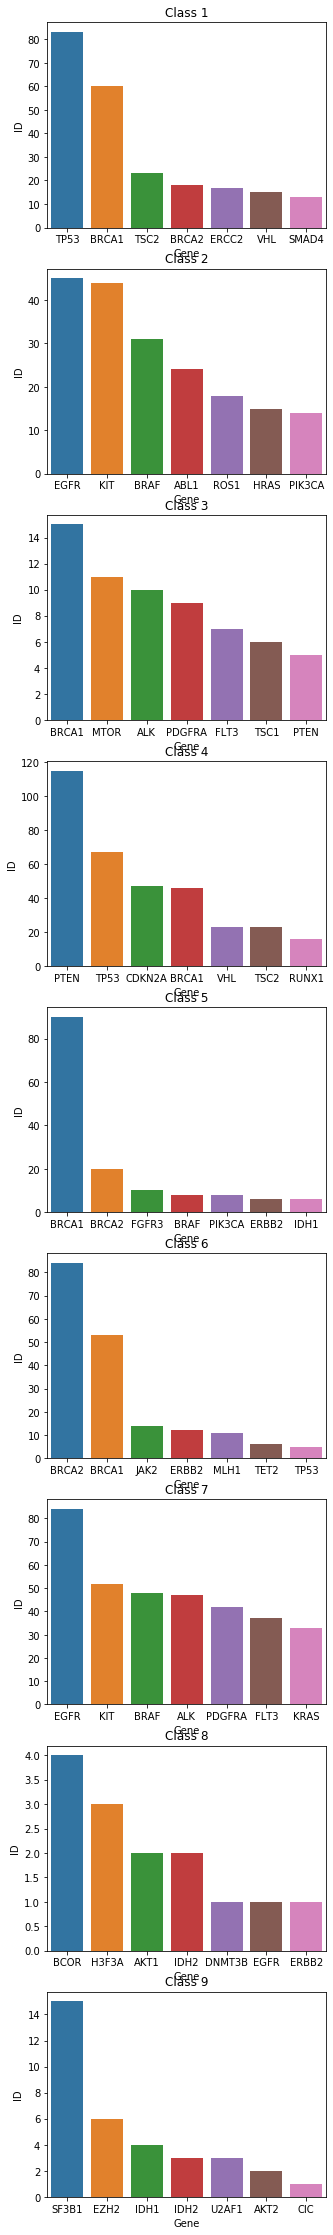

In [7]:
_, axs = plt.subplots(nrows=9, figsize=(5,40))

#print('Most frequently associated genes')
for i in train_variants['Class'].unique():
    
    gene_count_grp = train_variants[train_variants['Class']==i].groupby('Gene')['ID'].count().reset_index()
    sorted_grp = gene_count_grp.sort_values('ID', ascending=False)[:7]
    high_gene = sorted_grp['Gene'].iloc[0]
    high_frq = sorted_grp['ID'].iloc[0]
    print('class', i , ':' , high_gene, '(', high_frq, 'counts)')
    title_name = 'Class '+ str(i)
    sns.barplot(x='Gene', y='ID', data=sorted_grp, ax=axs[i-1]).set_title(title_name);

These were some nice analysis, but the question we need to answer is <b>genetic mutation associated with these genes</b> rather than the genes themselves

It brings us to study the next feature: text-based clinical description

### loading csv files

In [8]:
training_text_df = pd.read_csv('msk_dataset/training_text', sep="\|\|", engine='python', header=None, skiprows=1, names=['ID','Text'])
test_text_df = pd.read_csv('msk_dataset/test_text', sep="\|\|", engine='python', header=None, skiprows=1, names=['ID','Text'])
#these arguments are needed as the file is basically a long list of characters

In [9]:
training_text_df['Text'][0]

"Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1

This is very informative, but nobody has time for these!

But still, let's further look into this

In [10]:
training_text_df.head(10)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
5,5,Oncogenic mutations in the monomeric Casitas B...
6,6,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL is a negative regulator of activated recep...
8,8,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,Abstract Juvenile myelomonocytic leukemia (JM...


It seems like some elements are repeating. Let's find out!

In [11]:
len(training_text_df['Text'].unique())

1921

Now let's make a new feature (length of each text) and add it onto our dataframe so we can further analyze this new feature.

In [12]:
#training_text_only_df = training_text_df['Text']
for i in training_text_df['ID']:
    train_variants.at[i, 'Text'] = training_text_df['Text'][i] #.at is A LOT FASTER than ix/loc/iloc
    train_variants.at[i, 'Text_length'] = len(str(training_text_df['Text'][i]))

train_variants.head(10)
#len(train_variants['ID'])

,ID,Gene,Variation,Class,Text,Text_length
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,39714.0
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,36787.0
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,36787.0
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,36284.0
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,41338.0
5,5,CBL,V391I,4,Oncogenic mutations in the monomeric Casitas B...,41338.0
6,6,CBL,V430M,5,Oncogenic mutations in the monomeric Casitas B...,41338.0
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...,99044.0
8,8,CBL,Y371H,4,Abstract Juvenile myelomonocytic leukemia (JM...,79873.0
9,9,CBL,C384R,4,Abstract Juvenile myelomonocytic leukemia (JM...,38534.0


Let's see which genotypes (Text) are most frequently associated with each class

In [13]:
#print('Most frequently associated genotypes' + '\n')
for i in train_variants['Class'].unique():
    
    gene_count_grp = train_variants[train_variants['Class']==i].groupby('Text')['ID'].count().reset_index()
    sorted_grp = gene_count_grp.sort_values('ID', ascending=False)[:7]
    for j in range(3):
        high_gene = sorted_grp['Text'].iloc[j]
        high_frq = sorted_grp['ID'].iloc[j]
        print('class', i , ':' , high_gene[:30] + '...', '(', high_frq, 'counts)')
    print('')

class 1 : Tuberous sclerosis complex (TS... ( 16 counts)
class 1 : Genetic screening of the breas... ( 15 counts)
class 1 : The increasing application of ... ( 10 counts)

class 2 :  Abstract  Mutations in the Bc... ( 11 counts)
class 2 : Since Notch phenotypes in Dros... ( 7 counts)
class 2 : Hypoxia inducible factors (HIF... ( 6 counts)

class 3 : Genes encoding components of t... ( 10 counts)
class 3 : In the era of personalized med... ( 7 counts)
class 3 : Mutations in the juxtamembrane... ( 7 counts)

class 4 : The PTEN (phosphatase and tens... ( 49 counts)
class 4 : The tumor suppressor gene PTEN... ( 24 counts)
class 4 : Tuberous sclerosis complex (TS... ( 13 counts)

class 5 : Mutations in BRCA1 and BRCA2 a... ( 35 counts)
class 5 : Genetic screening of the breas... ( 15 counts)
class 5 : Frequent genetic alterations d... ( 9 counts)

class 6 : Mutation screening of the brea... ( 47 counts)
class 6 : Germline mutations of the brea... ( 28 counts)
class 6 : Twenty percent of ind

This is great because certain texts are uniquely associated with each class!

Before we feed this into a machine learning algorithm, let's see how many missing observations we have in our dataset

In [14]:
train_variants.describe()

,ID,Class,Text_length
count,3321.000000,3321.000000,3321.000000
mean,1660.000000,4.365854,63754.173141
std,958.834449,2.309781,52293.405846
min,0.000000,1.000000,3.000000
25%,830.000000,2.000000,31355.000000
50%,1660.000000,4.000000,46248.000000
75%,2490.000000,7.000000,80303.000000
max,3320.000000,9.000000,524532.000000


In [15]:
train_variants[train_variants['Text_length']<500]

,ID,Gene,Variation,Class,Text,Text_length
1109,1109,FANCA,S1088F,1,NaN,3.0
1277,1277,ARID5B,Truncating Mutations,1,NaN,3.0
1407,1407,FGFR3,K508M,6,NaN,3.0
1613,1613,VHL,L158Q,4,The case of a 40-year-old woman with severe ed...,337.0
1639,1639,FLT1,Amplification,6,NaN,3.0
2755,2755,BRAF,G596C,7,NaN,3.0


It seems like the missing observation is labeled as "NaN", so let's calculate the proportion of mission observations

In [16]:
print(len(train_variants[train_variants['Text_length']==3])/len(train_variants['Text_length'])*100, '%')

0.15055706112616682 %


Now let's see if we can finally answer the question by feeding our new feature into <b>Linear Support Vector Classifier</b>

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

nrml_train_variants_textl = min_max_scaler.fit_transform(train_variants['Text_length'].values.reshape(-1,1))

Before the MinMaxScaler, the array was normalized by root mean square which gave me a poorer result

In [18]:
#nrml_train_variants_textl = train_variants['Text_length'] / np.sqrt(np.sum(train_variants['Text_length']**2))
#nrml_train_variants_class = train_variants['Class'] / np.sqrt(np.sum(train_variants['Class']**2))

In [19]:
def optimized_LinearSVC(tsize, rnd):
    x_ax =[]
    max_val = 0
    for i in range(1,tsize):
        for j in range(1,rnd):
            X_train, X_test, y_train, y_test = train_test_split(nrml_train_variants_textl, train_variants['Class'], test_size=(i/1000), random_state=j)
            svc=LinearSVC(max_iter=3000, C=1)
            SVC_model=svc.fit(X_train , y_train)
            svc_score=SVC_model.score(X_test , y_test)
            if max_val < svc_score:
                max_val, max_tsize, max_rnd = svc_score, i, j
        print(tsize-i, 'iteration(s) left')
    return max_val, max_tsize, max_rnd

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train_variants['Text_length'], train_variants['Class'])

In [21]:
print(X_train.shape)
X_train[:5]

(2490,)


1383     22101.0
983     158298.0
1936     24829.0
1007     25965.0
827      79068.0
Name: Text_length, dtype: float64

In [22]:
print(X_test.shape)
X_test[:5]

(831,)


43      128128.0
1217     35768.0
1610     44199.0
3151    136570.0
2421    127545.0
Name: Text_length, dtype: float64

In [23]:
print(y_train.shape)
y_train[:5]

(2490,)


1383    1
983     2
1936    7
1007    4
827     1
Name: Class, dtype: int64

In [24]:
print(y_test.shape)
y_test[:5]

(831,)


43      1
1217    5
1610    1
3151    2
2421    1
Name: Class, dtype: int64

In [27]:
'''#test_text_only_df = test_text_df['Text']
#print(test_variants)
for i in test_variants['ID']:
    test_variants.at[i, 'Text'] = test_text_df['Text'][i] #.at is A LOT FASTER than ix/loc/iloc
    test_variants.at[i, 'Text_length'] = len(str(test_text_df['Text'][i]))

test_variants.head(10)
'''

"#test_text_only_df = test_text_df['Text']\n#print(test_variants)\nfor i in test_variants['ID']:\n    test_variants.at[i, 'Text'] = test_text_df['Text'][i] #.at is A LOT FASTER than ix/loc/iloc\n    test_variants.at[i, 'Text_length'] = len(str(test_text_df['Text'][i]))\n\ntest_variants.head(10)\n"

In [34]:
#test_variants.tail(10)

In [29]:
from sklearn.svm import LinearSVC
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import scale
#from sklearn.svm import SVC

In [30]:
def optimized_LinearSVC(tsize, rnd):
    x_ax =[]
    max_val = 0
    for i in range(1,tsize):
        for j in range(1,rnd):
            X_train, X_test, y_train, y_test = train_test_split(nrml_train_variants_textl, train_variants['Class'], test_size=(i/1000), random_state=j)
            svc=LinearSVC(max_iter=3000, C=1)
            SVC_model=svc.fit(X_train , y_train)
            svc_score=SVC_model.score(X_test , y_test)
            if max_val < svc_score:
                max_val, max_tsize, max_rnd = svc_score, i, j
        print(tsize-i, 'iteration(s) left')
    return max_val, max_tsize, max_rnd

In [31]:
#X_train.head()
X_train

1383     22101.0
983     158298.0
1936     24829.0
1007     25965.0
827      79068.0
808      29989.0
644      85196.0
87      121072.0
1404     36749.0
699      45604.0
62       21881.0
2345     20975.0
2771     51262.0
31      139523.0
2701     47142.0
1681     49654.0
2777     22653.0
3026     43110.0
1911      6169.0
1302     57256.0
1958     53971.0
1511     28883.0
2221    114930.0
1671     27400.0
1873     28732.0
2755         3.0
1148    101233.0
1430    125465.0
871      40801.0
3009    141638.0
          ...   
2611     78217.0
2260     42875.0
1693     26600.0
1979     59686.0
581      10039.0
2078     46360.0
283      45596.0
836      11835.0
714      46801.0
1476     23708.0
1836     79247.0
3056     62592.0
70      102138.0
772      44543.0
1917     10278.0
2433     43061.0
1803     92175.0
2980      2681.0
2225     42875.0
2991    106564.0
2891     51019.0
1553     47950.0
1690     40168.0
1160     52739.0
2271     42875.0
698      20315.0
2073     46360.0
716      38272

In [32]:
max_val, max_tsize, max_rnd = optimized_LinearSVC(10, 20)

9 iteration(s) left
8 iteration(s) left
7 iteration(s) left
6 iteration(s) left
5 iteration(s) left
4 iteration(s) left
3 iteration(s) left
2 iteration(s) left
1 iteration(s) left


In [33]:
print('Accuracy:', max_val, '\n'
      'Optimal test_size:', max_tsize/1000, '\n'
      'Optimal random_state:', max_rnd)

Accuracy: 0.7 
Optimal test_size: 0.003 
Optimal random_state: 14


In [ ]:
do it on the testset next

## 8) What is your _y_-variable?
For final project, you will need to perform a statistical model. This means you will have to accurately predict some y-variable for some combination of x-variables. From your problem statement in part 7, what is that y-variable?

In [ ]:
KNN
RDG
DTC